In [21]:
# Initialization
import numpy as np
import scipy as sp
from ase import Atoms
from ase.io.trajectory import Trajectory
from matplotlib import pyplot as plt

plt.rcParams['text.usetex'] = True # Allows for TeX in figures

# Importing the trajectories
traj_AIMD = Trajectory('Data/Dynamics.traj')       # Our AIMD
traj_Na   = Trajectory('Na-aimd/NaCluster24.traj') # Theirs w Na+
traj_H2O  = Trajectory('Na-aimd/cluster24.traj')   # Theirs w/o Na+

C:\Users\hemda\AppData\Roaming\Python\Python39\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


4.0038
4.390571428571429


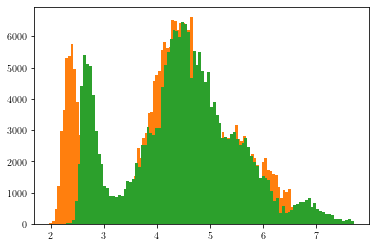

In [22]:
# Finding the RDF and the first solvation shell
def RDF(traj,a_id=72,N=73,start=0,stop=None):
    '''
    traj  - Trajectory object
    a_id  - ID of atom to be analyzed
    N     - Amount of atoms
    start - Initial step of trajectory
    stop  - Final step of trajectory
    '''
    if stop == None:
        stop = len(traj) # Default stop snapshot is the final one
    
    d = np.zeros([])         # Empty distance array to be filled
    d_sum = np.zeros(N-1)
    V = traj[0].get_volume() # Cell volume
    rho = V/len(traj[0])     # Particle density

    w = traj[0].get_cell_lengths_and_angles()[0] # Cell width

    # Distance from Na+ to O for each timestep
    for i in range(start,stop):
        atoms = traj[i]
        d_i = atoms.get_distances(a_id,
                atoms.get_atomic_numbers()==8,mic=True) # Distances to oxygen
                
        d_i = np.where(d_i<w,d_i,d_i-w) # Applying the boundary condition

        d = np.append(d,d_i) # Add to list
    
    d = d[d != 0] # Disregard eventual distances to the atom itself 
    
    d_sum *= len(traj)**-1
    d_sum = np.sort(d_sum)

    # Finding the RDF g(r)
    hist = np.histogram(d,bins=100) # Data binning
    plt.hist(d,bins=100)
    dr   = hist[1][1] - hist[1][0]
    r    = hist[1][1:] - dr/2
    dn_r = hist[0]/(stop-start)

    gPrime = dn_r*(4*np.pi*r**2*dr*rho)**-1
    #g = dn_r*(dr)**-1

    # Finding the first solvation shell
    r_1,r_2 = 3,8 # Approximated radii
    minapprox = int((r_1-r[0])/dr) # Approximation of first minimum
    min = np.argmin(gPrime[minapprox-r_2:minapprox+r_2]) + minapprox - r_2

    SH = sum(hist[0][:min])/(stop-start) # Solvation shell

    return [r,gPrime], SH

data,SH = RDF(traj_AIMD) # Our AIMD run
data_Na,SH_Na = RDF(traj_Na,start=3500) # Theirs w Na
data_H2O,SH_H2O = RDF(traj_H2O,a_id=4,N=72,start=2000) # Theirs w/o Na

In [ ]:
# Plotting

save_figs = False

# Individual figures
fig1,ax1 = plt.subplots(figsize=(7,7)) # Our AIMD
fig2,ax2 = plt.subplots(figsize=(7,7)) # Theirs w Na
fig3,ax3 = plt.subplots(figsize=(7,7)) # Theirs w/o Na

ax    = [ax1,ax2,ax3]
radii = [data[0],data_Na[0],data_H2O[0]]
rdf   = [data[1],data_Na[1],data_H2O[1]]
label = [r'Our data (Na$^+$)',r'Git data (Na$^+$)',r'Git data (H$_2$O)']

for i in range(3):
    ax[i].plot(radii[i][20:],rdf[i][20:],label=label[i])
    ax[i].tick_params(axis = 'both', labelsize = 15)
    ax[i].set_xlabel(r"Radius [Å]",fontsize=20)
    ax[i].set_ylabel(r"g(r)",fontsize=20)
    ax[i].set_xlim([radii[i][20],radii[i][-1]])
    ax[i].set_ylim([0,1.05*np.amax(rdf[i][20:])])
    ax[i].grid()
    ax[i].legend(fontsize=19)

# Superimposed plot
fig_all,ax_all = plt.subplots(figsize=(10,7))

ax_all.plot(radii[0][20:],rdf[0][20:],label=r'Our data (Na$^+$)')
ax_all.plot(radii[1][20:],rdf[1][20:],label=r'Git data (Na$^+$)')
ax_all.plot(radii[2][20:],rdf[2][20:],label=r'Git data (H$_2$O)')

ax_all.tick_params(axis = 'both', labelsize = 15)
ax_all.set_xlabel(r"Radius [Å]",fontsize=20)
ax_all.set_ylabel(r"g(r)",fontsize=20)
ax_all.set_xlim([radii[0][20],radii[0][-1]])
ax_all.set_ylim([0,0.016])
ax_all.grid()
ax_all.legend(fontsize=19)

# Saving the figures
if save_figs == True:
    fig1.savefig('Figures/RDF our NA.pdf',bbox_inches='tight')
    fig2.savefig('Figures/RDF their Na.pdf',bbox_inches='tight')
    fig3.savefig('Figures/RDF Only H2O.pdf',bbox_inches='tight')
    fig_all.savefig('Figures/RDF superimposed.pdf',bbox_inches='tight')

In [23]:
print(f'Our Na:    SH = {SH}')
print(f'Their Na:  SH = {SH_Na}')
print(f'Their H20: SH = {SH_H2O}')

Our Na:    SH = 4.575
Their Na:  SH = 4.390571428571429
Their H20: SH = 4.0038
